## **Classification Analysis: Predicting 2023 Criteria Air Contaminant Levels Using the National Pollutant Release Inventory (NPRI) Dataset**

### **Group members:**
1. Varinder Kaur (vkaur65@norquest.ca)
2. Satvir Kaur Mehra (smehra06@norquest.ca)
3. Gurraj Kaur Gill (ggill533@norquest.ca)
4. Gurleen Kaur Rahanoo (glnu890@norquest.ca)

### **Course:**
Machine Learning 1

### **Instructor:**
Mohammad Ajallooeian

### **Date:**
October 29, 2024

### **Import required libraries**

In [ ]:
# Import the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier  # Example classifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

### **Load the Dataset:** <br>
There are three sheets in the dataset : releases, disposals and transfers, and comments. Since we need to predict the trends for releases, we will only load that sheet from the excel file provided.

In [ ]:
import zipfile
#  get the needed data and store it in variable "releases_df"
try:
    releases_df = pd.read_excel('NPRI_2000-2022 (1).xlsx', sheet_name='Releases 2000-2020', engine='openpyxl')
    # Explicitly using openpyxl engine to handle xlsx files
except zipfile.BadZipFile:
    print("Error: The file might be corrupted or not a valid xlsx file.")
    #Try reading as an older Excel format
    try:
        releases_df = pd.read_excel('NPRI_2000-2022 (1).xlsx', sheet_name='Releases 2000-2020', engine='xlrd')
    except Exception as e:
        print(f"Error reading with xlrd engine: {e}")
        print("Please check if the file is a valid excel file and not corrupted.")

# to get the basic knowledge about dataframe, regarding how many null values and datatypes of columns
releases_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737516 entries, 0 to 737515
Data columns (total 28 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   Reporting_Year / Année                                 737516 non-null  int64  
 1   NPRI_ID / No_INRP                                      737516 non-null  int64  
 2   Number of employees                                    736900 non-null  object 
 3   Company_Name / Dénomination_sociale_de_l'entreprise    737516 non-null  object 
 4   Facility_Name / Installation                           736340 non-null  object 
 5   NAICS / Code_SCIAN                                     737516 non-null  int64  
 6   NAICS Title / Titre Code_SCIAN                         737516 non-null  object 
 7   PROVINCE                                               737516 non-null  object 
 8   City                              

### **Get the required data only:**<br>
We need to predict the trends for these criteria air contaminants:
1. Sulphur Dioxide
2. Nitrogen oxides
3. Volatile Organic Compounds
4. PM10 - Particulate Matter <= 10 Micrometers
5. PM2.5 - Particulate Matter <= 2.5 Micrometers
6. Carbon monoxide

We will extract the data that is related to these substances only.

In [ ]:
# select the features we are interested in
contaminants_of_interest =[
    'Sulphur dioxide',
    'Nitrogen oxides (expressed as nitrogen dioxide)',
    'Volatile Organic Compounds (VOCs)',
    'PM10 - Particulate Matter <= 10 Micrometers',
    'PM2.5 - Particulate Matter <= 2.5 Micrometers',
    'Carbon monoxide'
]

# Filter the DataFrame and update releases_df
releases_df = releases_df[releases_df['Substance Name (English) / Nom de substance (Anglais)'].isin(contaminants_of_interest)]

### **Basic Data Cleaning:**<br>
1. There are many columns related to releases that are released to different kinds of media, it makes the data difficult to understand. We will gather those columns to a limited number of columns, so that the dataset looks clean and readable.
2. There are many columns that are not useful for predicting trends, we will drop them.
3. Check any missing values.

In [ ]:
# Create a new column 'Total_Releases' by summing the release-related columns, including 'Sum of release to all media (<1tonne)'
# To keep track of where the chemicals are released, we will also store the 'releases' in three basic columns according to air, land and water

# Get a column for releases into "air"
releases_df['Air_Releases'] = releases_df[
    [
        'Release to Air - Fugitive',
        'Release to Air - Other Non-Point ',
        'Release to Air - Road dust  ',
        'Release to Air - Spills ',
        'Release to Air - Stack / Point  ',
        'Release to Air - Storage / Handling ',
    ]
].sum(axis=1)

# Get a column for releases into "land"
releases_df['Land_Releases'] = releases_df[
    [
        'Releases to Land - Leaks',
        'Releases to Land - Other ',
        'Releases to Land - Spills '
    ]
].sum(axis=1)

# Get a column for releases into "water"
releases_df['Water_Releases'] = releases_df[
    [
        'Releases to Water Bodies - Direct Discharges ',
        'Releases to Water Bodies - Leaks',
        'Releases to Water Bodies - Spills '
    ]
].sum(axis=1)

# Get a column woth total amount released
releases_df['Total_Releases'] = releases_df[
    [
        'Air_Releases',
        'Land_Releases',
        'Water_Releases',
        'Sum of release to all media (<1tonne)'
    ]
].sum(axis=1)
# Display the new columns to check the results
releases_df[['Air_Releases', 'Land_Releases', 'Water_Releases', 'Total_Releases']].head()


,Air_Releases,Land_Releases,Water_Releases,Total_Releases
20037,1376.83,0.0,0.0,1376.83
20040,1763.15,0.0,0.0,1763.15
20059,211.40,0.0,0.0,211.40
20060,191.60,0.0,0.0,191.60
20061,491.70,0.0,0.0,491.70


In [ ]:
releases_df.drop(
    [
        'Release to Air - Fugitive',
        'Release to Air - Other Non-Point ',
        'Release to Air - Road dust  ',
        'Release to Air - Spills ',
        'Release to Air - Stack / Point  ',
        'Release to Air - Storage / Handling ',
        'Releases to Land - Leaks',
        'Releases to Land - Other ',
        'Releases to Land - Spills ',
        'Releases to Water Bodies - Direct Discharges ',
        'Releases to Water Bodies - Leaks',
        'Releases to Water Bodies - Spills ',
        'Sum of release to all media (<1tonne)',
    ],
    axis=1,
    inplace=True
)

### **Transforming Release Data**

In this step, we are organizing the environmental release data to make it easier to work with. We select only the important information we need, change the layout so we can analyze it better, and convert the year to a proper date format. This will help us understand the data more clearly and make our analysis easier.


In [ ]:
# Select relevant columns
releases_filtered = releases_df[['Reporting_Year / Année', 'Substance Name (English) / Nom de substance (Anglais)',
                                 'Number of employees',
                                 'Air_Releases', 'Land_Releases', 'Water_Releases',
                                 'Total_Releases'
                                      ]]

# Melt the DataFrame to long format
releases_long = releases_filtered.melt(
    id_vars=['Reporting_Year / Année', 'Substance Name (English) / Nom de substance (Anglais)',
             'Number of employees'],
    var_name='Release_Type',
    value_name='Release'
)

# Convert the year to datetime format
releases_long['Reporting_Year / Année'] = pd.to_datetime(releases_long['Reporting_Year / Année'], format='%Y')

# Inspect the transformed DataFrame
print(releases_long.head())

  Reporting_Year / Année  \
0             2002-01-01   
1             2002-01-01   
2             2002-01-01   
3             2002-01-01   
4             2002-01-01   

  Substance Name (English) / Nom de substance (Anglais) Number of employees  \
0    Nitrogen oxides (expressed as nitrogen dioxide)                    440   
1                                    Carbon monoxide                    440   
2        PM10 - Particulate Matter <= 10 Micrometers                    440   
3      PM2.5 - Particulate Matter <= 2.5 Micrometers                    440   
4                  Volatile Organic Compounds (VOCs)                    440   

   Release_Type  Release  
0  Air_Releases  1376.83  
1  Air_Releases  1763.15  
2  Air_Releases   211.40  
3  Air_Releases   191.60  
4  Air_Releases   491.70  


In [ ]:
# Check for missing values
print(releases_long.isnull().sum())

Reporting_Year / Année                                      0
Substance Name (English) / Nom de substance (Anglais)       0
Number of employees                                      1532
Release_Type                                                0
Release                                                     0
dtype: int64


In [ ]:
# first we need to convert number of employees to numeric form, because it is in object type
releases_long['Number of employees'] = pd.to_numeric(releases_long['Number of employees'], errors='coerce')
# to fill the missing values in employees column
releases_long['Number of employees'].fillna(releases_long['Number of employees'].mean())

,Number of employees
0,440.0
1,440.0
2,440.0
3,440.0
4,440.0
...,...
1563295,20.0
1563296,170.0
1563297,170.0
1563298,170.0


In [ ]:
releases_long.head()

,Reporting_Year / Année,Substance Name (English) / Nom de substance (Anglais),Number of employees,Release_Type,Release
0,2002-01-01,Nitrogen oxides (expressed as nitrogen dioxide),440.0,Air_Releases,1376.83
1,2002-01-01,Carbon monoxide,440.0,Air_Releases,1763.15
2,2002-01-01,PM10 - Particulate Matter <= 10 Micrometers,440.0,Air_Releases,211.40
3,2002-01-01,PM2.5 - Particulate Matter <= 2.5 Micrometers,440.0,Air_Releases,191.60
4,2002-01-01,Volatile Organic Compounds (VOCs),440.0,Air_Releases,491.70


### **Creating Lag Features for Release Data**

In this step, we are adding new columns to our data to show how much the releases of each substance have changed over the past one, two, and three years. These new columns, called "Lag_1," "Lag_2," and "Lag_3," help us see trends in the data by comparing current releases to past values. We also remove any rows that don’t have complete lag data to ensure our analysis is accurate. This will make it easier to understand changes in environmental releases over time.


In [ ]:
# Create multiple lag features (previous 1, 2, and 3 years)
releases_long['Lag_1'] = releases_long.groupby(['Substance Name (English) / Nom de substance (Anglais)', 'Release_Type', 'Number of employees'])['Release'].shift(1)
releases_long['Lag_2'] = releases_long.groupby(['Substance Name (English) / Nom de substance (Anglais)', 'Release_Type', 'Number of employees'])['Release'].shift(2)
releases_long['Lag_3'] = releases_long.groupby(['Substance Name (English) / Nom de substance (Anglais)', 'Release_Type', 'Number of employees'])['Release'].shift(3)

# Drop rows where any of the lag values are missing (optional)
releases_long.dropna(subset=['Lag_1', 'Lag_2', 'Lag_3'], inplace=True)

# Check the updated DataFrame with lag features
releases_long.head()

,Reporting_Year / Année,Substance Name (English) / Nom de substance (Anglais),Number of employees,Release_Type,Release,Lag_1,Lag_2,Lag_3
189,2002-01-01,PM10 - Particulate Matter <= 10 Micrometers,150.0,Air_Releases,3.321,5.243,0.614,0.34
191,2002-01-01,PM2.5 - Particulate Matter <= 2.5 Micrometers,150.0,Air_Releases,1.370,3.470,0.614,0.30
217,2002-01-01,Volatile Organic Compounds (VOCs),63.0,Air_Releases,0.195,5.269,0.000,6.51
243,2002-01-01,Volatile Organic Compounds (VOCs),150.0,Air_Releases,32.851,1315.000,16.435,22.70
420,2002-01-01,Volatile Organic Compounds (VOCs),24.0,Air_Releases,5.500,48.159,61.455,30.50


### **Bining the Data:**
We will bin the data into: low, medium and high releases. We have continuous pollutant releases data and we need to convert it to categories so we use bining.

In [ ]:

# Define the number of bins (3 bins: Low, Medium, High)
num_bins = 3

# Group by 'Substance Name', 'Reporting Year', 'Number of Employees'
releases_long['Release_Category'] = releases_long.groupby(
    ['Substance Name (English) / Nom de substance (Anglais)',
     'Reporting_Year / Année',
     'Number of employees',
     ]
)['Release'].transform(
    lambda x: pd.qcut(x.rank(method='first'), num_bins, labels=['Low', 'Medium', 'High'])
)

# Check that the necessary columns are still present
print(releases_long[['Reporting_Year / Année',
                     'Substance Name (English) / Nom de substance (Anglais)',
                     'Number of employees',
                     'Release_Type',
                     'Release',
                     'Release_Category',
                     'Lag_1',
                     'Lag_2',
                     'Lag_3',

                     ]].head())


    Reporting_Year / Année  \
189             2002-01-01   
191             2002-01-01   
217             2002-01-01   
243             2002-01-01   
420             2002-01-01   

    Substance Name (English) / Nom de substance (Anglais)  \
189        PM10 - Particulate Matter <= 10 Micrometers      
191      PM2.5 - Particulate Matter <= 2.5 Micrometers      
217                  Volatile Organic Compounds (VOCs)      
243                  Volatile Organic Compounds (VOCs)      
420                  Volatile Organic Compounds (VOCs)      

     Number of employees  Release_Type  Release Release_Category     Lag_1  \
189                150.0  Air_Releases    3.321             High     5.243   
191                150.0  Air_Releases    1.370             High     3.470   
217                 63.0  Air_Releases    0.195           Medium     5.269   
243                150.0  Air_Releases   32.851             High  1315.000   
420                 24.0  Air_Releases    5.500           Medi

### **Data Preparation:**<br>
Getting separate dataframe for each substance.

In [ ]:
# List of substances to focus on
target_substances = ['Sulphur dioxide', 'Nitrogen oxides (expressed as nitrogen dioxide)',
                     'Volatile Organic Compounds (VOCs)',
                     'PM10 - Particulate Matter <= 10 Micrometers',
                     'PM2.5 - Particulate Matter <= 2.5 Micrometers',
                     'Carbon monoxide']

# Create a dictionary to store each substance's data separately
substance_data = {}

# Filter the dataset for each substance and store it in the dictionary
for substance in target_substances:
    substance_data[substance] = releases_long[releases_long['Substance Name (English) / Nom de substance (Anglais)'] == substance]
    print(f"Substance: {substance}")
    print(substance_data[substance].head())
# Check the dataset for one substance (example: Sulphur Dioxide)
#substance_data['Sulphur dioxide'].head()



Substance: Sulphur dioxide
     Reporting_Year / Année  \
665              2002-01-01   
915              2002-01-01   
928              2002-01-01   
941              2002-01-01   
1181             2002-01-01   

     Substance Name (English) / Nom de substance (Anglais)  \
665                                     Sulphur dioxide      
915                                     Sulphur dioxide      
928                                     Sulphur dioxide      
941                                     Sulphur dioxide      
1181                                    Sulphur dioxide      

      Number of employees  Release_Type    Release     Lag_1     Lag_2  \
665                 200.0  Air_Releases      0.254    88.700   134.281   
915                  20.0  Air_Releases   3839.680     0.000     0.095   
928                  20.0  Air_Releases   1348.470  3839.680     0.000   
941                  75.0  Air_Releases   1898.710   413.430  1439.300   
1181                100.0  Air_Releases  45

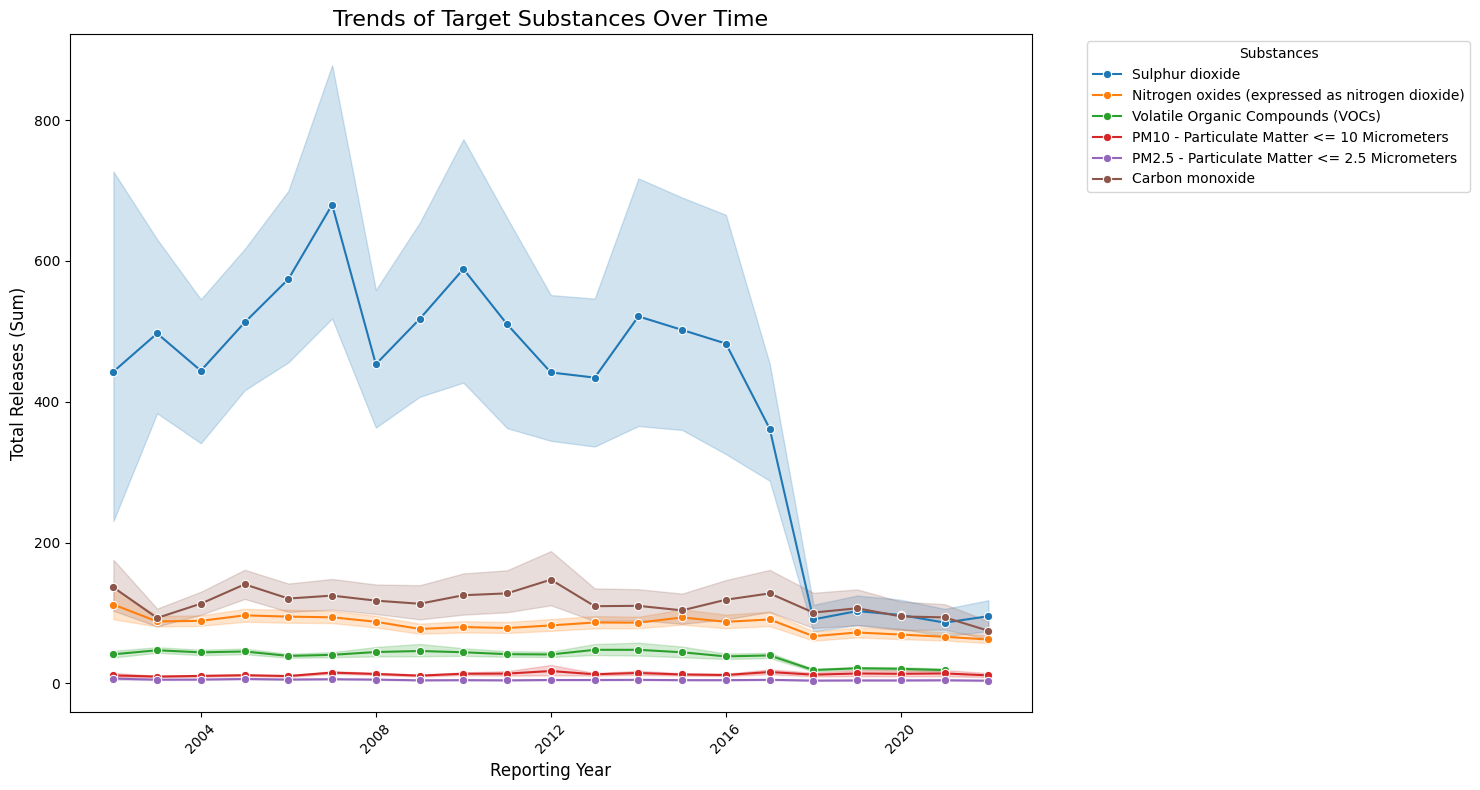

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size
plt.figure(figsize=(15, 8))

# Iterate through each substance in the dictionary
for substance, data in substance_data.items():
    # Create a line plot for each substance
    sns.lineplot(x='Reporting_Year / Année', y='Release', data=data, label=substance, marker='o')

# Add title and labels
plt.title('Trends of Target Substances Over Time', fontsize=16)
plt.xlabel('Reporting Year', fontsize=12)
plt.ylabel('Total Releases (Sum)', fontsize=12)

# Rotate the x-axis labels for readability
plt.xticks(rotation=45)

# Show the legend
plt.legend(title='Substances', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


### **MODELS FOR EACH SUBSTANCE**

In [ ]:
def process_substance(substance_name, substance_data):
    # Step 1: Extract data for the given substance
    data = substance_data[substance_name]

    # Step 2: Prepare the features and target variable
    X = data[['Lag_1', 'Lag_2', 'Lag_3', 'Number of employees']]

    # Target variable
    y = data['Release_Category']

    # Combine X and y for shuffling
    combined_data = pd.concat([X, y], axis=1)

    # Step 3: Drop rows with any NaNs in features or target
    combined_data = combined_data.dropna()

    # Check if there are still any NaNs in the target variable
    if combined_data['Release_Category'].isnull().any():
        print(f"Warning: Found NaN values in {substance_name}'s target variable after filtering. Aborting processing.")
        return None, None  # Return None if NaN is found

    # Separate back into features and target variable after cleaning
    X_clean = combined_data.drop('Release_Category', axis=1)
    y_clean = combined_data['Release_Category']

    # Encode categorical variables
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y_clean)

    # Shuffle the combined dataset
    combined_data_shuffled = combined_data.sample(frac=1, random_state=42).reset_index(drop=True)

    # Split the data into train and test sets (80% train, 20% test)
    train_size = int(0.8 * len(combined_data_shuffled))
    train_data = combined_data_shuffled[:train_size]
    test_data = combined_data_shuffled[train_size:]

    # Further split the training set into training and validation sets (80% train, 20% validation)
    val_size = int(0.2 * len(train_data))
    val_data = train_data[-val_size:]
    train_data = train_data[:-val_size]

    # Separate the features and target variable for each set
    X_train = train_data.drop('Release_Category', axis=1)
    y_train = train_data['Release_Category']
    X_val = val_data.drop('Release_Category', axis=1)
    y_val = val_data['Release_Category']
    X_test = test_data.drop('Release_Category', axis=1)
    y_test = test_data['Release_Category']

    # Define the model
    model = RandomForestClassifier(random_state=42)

    # Set up the parameter grid for hyperparameter tuning
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # Perform Randomized Search
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                                       n_iter=10, scoring='f1_weighted', cv=3, verbose=2, n_jobs=-1)
    random_search.fit(X_train, y_train)

    # Get the best parameters and estimator
    best_model = random_search.best_estimator_

    # Make predictions with the best model for validation phase
    y_val_pred_best = best_model.predict(X_val)

    # Evaluate the model on the validation set
    print(f"Validation Classification Report for {substance_name}:")
    print(classification_report(y_val, y_val_pred_best))

    print(f"Validation Confusion Matrix for {substance_name}:")
    print(confusion_matrix(y_val, y_val_pred_best))

    # Make predictions on the test set to evaluate the final model
    y_test_pred_best = best_model.predict(X_test)

    # Evaluate the model on the test set
    print(f"Test Classification Report for {substance_name}:")
    print(classification_report(y_test, y_test_pred_best))

    print(f"Test Confusion Matrix for {substance_name}:")
    print(confusion_matrix(y_test, y_test_pred_best))

    return best_model, random_search.best_params_

# Now, call the function for each substance
models = {}
for substance in target_substances:
    print(f"Processing {substance}...")
    model, best_params = process_substance(substance, substance_data)
    models[substance] = model  # Store the trained model for later use

    print(f"Best parameters for {substance}: {best_params}")
    print("------------------------------------------------------------")


Processing Sulphur dioxide...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Validation Classification Report for Sulphur dioxide:
              precision    recall  f1-score   support

        High       0.77      0.72      0.74      5455
         Low       0.57      0.44      0.50      5081
      Medium       0.46      0.59      0.52      4969

    accuracy                           0.59     15505
   macro avg       0.60      0.58      0.58     15505
weighted avg       0.60      0.59      0.59     15505

Validation Confusion Matrix for Sulphur dioxide:
[[3928  305 1222]
 [ 587 2254 2240]
 [ 615 1429 2925]]
Test Classification Report for Sulphur dioxide:
              precision    recall  f1-score   support

        High       0.77      0.73      0.75      6969
         Low       0.56      0.44      0.50      6315
      Medium       0.45      0.59      0.51      6099

    accuracy                           0.59     19383
   macro avg       0.60      0.59      0.59     19

In [ ]:
import pandas as pd

# Create a dictionary to store each substance's data separately
substance_data = {}

# Filter the dataset for each substance and store it in the dictionary
for substance in target_substances:
    substance_data[substance] = releases_long[releases_long['Substance Name (English) / Nom de substance (Anglais)'] == substance]

# Create a list to hold the results
recent_data = []

# Loop through each substance and retrieve recent data
for substance, data in substance_data.items():
    # Find the most recent year
    recent_year = data['Reporting_Year / Année'].max()

    # Filter the data for the most recent year
    recent_entry = data[data['Reporting_Year / Année'] == recent_year]

    # Check if there is any data for that year
    if not recent_entry.empty:
        number_of_employees = recent_entry['Number of employees'].values[0]

        # Append the results to the list
        recent_data.append({
            'Substance': substance,
            'Reporting Year': recent_year,
            'Number of Employees': number_of_employees
        })

# Convert the results to a DataFrame for better visualization
substance_data_2023 = pd.DataFrame(recent_data)

# Display the results
print(substance_data_2023)




                                         Substance Reporting Year  \
0                                  Sulphur dioxide     2022-01-01   
1  Nitrogen oxides (expressed as nitrogen dioxide)     2022-01-01   
2                Volatile Organic Compounds (VOCs)     2021-01-01   
3      PM10 - Particulate Matter <= 10 Micrometers     2022-01-01   
4    PM2.5 - Particulate Matter <= 2.5 Micrometers     2022-01-01   
5                                  Carbon monoxide     2022-01-01   

   Number of Employees  
0                423.0  
1                423.0  
2                  5.0  
3                423.0  
4                423.0  
5                423.0  


In [ ]:
def predict_for_2023(substance_name, best_model, substance_data_2023):
    # Step 1: Prepare the 2023 data for the substance
    X_2023 = substance_data_2023[substance_name][['Lag_1', 'Lag_2', 'Lag_3', 'Number of employees']]

    # Check if any NaN values are present in the 2023 features
    if X_2023.isnull().any().any():
        print(f"Warning: Found NaN values in {substance_name}'s 2023 features. Aborting prediction.")
        return None

    # Step 2: Make predictions using the best model
    y_2023_pred = best_model.predict(X_2023)

    print(f"Predicted Release Categories for {substance_name} in 2023:")
    print(y_2023_pred)

    return y_2023_pred

# Now, call the prediction function for each substance
predictions_2023 = {}
for substance in target_substances:
    print(f"Predicting for {substance} in 2023...")
    predictions_2023[substance] = predict_for_2023(substance, models[substance], substance_data)
    print("------------------------------------------------------------")


Predicting for Sulphur dioxide in 2023...
Predicted Release Categories for Sulphur dioxide in 2023:
['High' 'High' 'High' ... 'High' 'High' 'Medium']
------------------------------------------------------------
Predicting for Nitrogen oxides (expressed as nitrogen dioxide) in 2023...
Predicted Release Categories for Nitrogen oxides (expressed as nitrogen dioxide) in 2023:
['High' 'High' 'High' ... 'High' 'Medium' 'High']
------------------------------------------------------------
Predicting for Volatile Organic Compounds (VOCs) in 2023...
Predicted Release Categories for Volatile Organic Compounds (VOCs) in 2023:
['Medium' 'High' 'Medium' ... 'High' 'High' 'High']
------------------------------------------------------------
Predicting for PM10 - Particulate Matter <= 10 Micrometers in 2023...
Predicted Release Categories for PM10 - Particulate Matter <= 10 Micrometers in 2023:
['High' 'High' 'High' ... 'High' 'High' 'High']
------------------------------------------------------------


In [ ]:
def predict_for_2023_aggregated(substance_name, best_model, substance_data_2023):
    # Step 1: Prepare the 2023 data for the substance
    X_2023 = substance_data_2023[substance_name][['Lag_1', 'Lag_2', 'Lag_3', 'Number of employees']]

    # Check if any NaN values are present in the 2023 features
    if X_2023.isnull().any().any():
        print(f"Warning: Found NaN values in {substance_name}'s 2023 features. Aborting prediction.")
        return None

    # Step 2: Aggregate the 2023 data (e.g., using the mean or median)
    X_2023_aggregated = X_2023.mean().to_frame().T  # Aggregating by mean, you can also use .median()

    # Step 3: Make a single prediction using the best model
    y_2023_pred_single = best_model.predict(X_2023_aggregated)

    print(f"Single predicted release category for {substance_name} in 2023 is: {y_2023_pred_single[0]}")

    return y_2023_pred_single[0]

# Now, call the prediction function for each substance
predictions_2023 = {}
for substance in target_substances:
    print(f"Predicting for {substance} in 2023...")
    predictions_2023[substance] = predict_for_2023_aggregated(substance, models[substance], substance_data)
    print("------------------------------------------------------------")


Predicting for Sulphur dioxide in 2023...
Single predicted release category for Sulphur dioxide in 2023 is: High
------------------------------------------------------------
Predicting for Nitrogen oxides (expressed as nitrogen dioxide) in 2023...
Single predicted release category for Nitrogen oxides (expressed as nitrogen dioxide) in 2023 is: High
------------------------------------------------------------
Predicting for Volatile Organic Compounds (VOCs) in 2023...
Single predicted release category for Volatile Organic Compounds (VOCs) in 2023 is: High
------------------------------------------------------------
Predicting for PM10 - Particulate Matter <= 10 Micrometers in 2023...
Single predicted release category for PM10 - Particulate Matter <= 10 Micrometers in 2023 is: High
------------------------------------------------------------
Predicting for PM2.5 - Particulate Matter <= 2.5 Micrometers in 2023...
Single predicted release category for PM2.5 - Particulate Matter <= 2.5 Micr

In [ ]:
def predict_for_2023_aggregated(substance_name, best_model, substance_data_2023):
    # Step 1: Prepare the 2023 data for the substance
    X_2023 = substance_data_2023[substance_name][['Lag_1', 'Lag_2', 'Lag_3', 'Number of employees']]

    # Check for NaN values and drop them
    if X_2023.isnull().any().any():
        print(f"Warning: Found NaN values in {substance_name}'s 2023 features. Dropping rows with NaN values.")
        X_2023 = X_2023.dropna()

    # Step 2: Check if there are remaining rows to predict
    if X_2023.empty:
        print(f"No valid data to predict for {substance_name} in 2023.")
        return None

    # Step 3: Aggregate the data (e.g., using median)
    X_2023_aggregated = X_2023.median().to_frame().T  # Using median for aggregation

    # Step 4: Make a single prediction using the best model
    y_2023_pred_single = best_model.predict(X_2023_aggregated)

    print(f"Single predicted release category for {substance_name} in 2023 is: {y_2023_pred_single[0]}")

    return y_2023_pred_single[0]

# Now, call the prediction function for each substance
predictions_2023 = {}
for substance in target_substances:
    print(f"Predicting for {substance} in 2023...")
    predictions_2023[substance] = predict_for_2023_aggregated(substance, models[substance], substance_data)
    print("------------------------------------------------------------")


Predicting for Sulphur dioxide in 2023...
Single predicted release category for Sulphur dioxide in 2023 is: Medium
------------------------------------------------------------
Predicting for Nitrogen oxides (expressed as nitrogen dioxide) in 2023...
Single predicted release category for Nitrogen oxides (expressed as nitrogen dioxide) in 2023 is: Low
------------------------------------------------------------
Predicting for Volatile Organic Compounds (VOCs) in 2023...
Single predicted release category for Volatile Organic Compounds (VOCs) in 2023 is: Low
------------------------------------------------------------
Predicting for PM10 - Particulate Matter <= 10 Micrometers in 2023...
Single predicted release category for PM10 - Particulate Matter <= 10 Micrometers in 2023 is: Low
------------------------------------------------------------
Predicting for PM2.5 - Particulate Matter <= 2.5 Micrometers in 2023...
Single predicted release category for PM2.5 - Particulate Matter <= 2.5 Micro